In [124]:
%matplotlib inline

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from fuzzywuzzy import fuzz
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
# from tabula import read_pdf

In [126]:
pd.set_option('display.max_columns', None)

In [127]:
def logistic_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    predictions = logisticRegr.predict(X_test)
    score = logisticRegr.score(X_test, y_test)
    cm = metrics.confusion_matrix(y_test, predictions)
    return (score, cm)

def knn(X,y, n = 2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    kneigh = KNeighborsClassifier(n_neighbors=n)
    kneigh.fit(X_train, y_train)
    predictions = kneigh.predict(X_test)
    score = kneigh.score(X_test,y_test)
    cm = metrics.confusion_matrix(y_test, predictions)
    return (score, cm)

def rand_forest(X,y, dept = 3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = RandomForestClassifier(max_depth=dept, random_state=0)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    score = clf.score(X_test,y_test)
    cm = metrics.confusion_matrix(y_test, predictions)
    return (score, cm)

def bayes(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictions = gnb.predict(X_test)
    score = gnb.score(X_test,y_test)
    cm = metrics.confusion_matrix(y_test, predictions)
    return (score, cm)

def find_dependencies(dataset, column1 = 'Country', values = [] , column2 = 'treatment', p_value = 0.05):
    '''This function checks if the null hypothesis H0 is rejected.
    Our H0 states: The two Columns are independant!
    Thus if our p value is less than givven threshold, this means the chance of getting this distribution for indepedant values
    is less than this threshold => meaning the columns must be dependant.
    
    ####################################################################
    dataset = provide Pandas DataFrame
    column1 = string like , first column to be tested, by default it is "Country"
    values  = string or list like , select values in the column that should be considered
    column2 = string like , second column to be test the correlation, by default it is our column "treatment" as we are interested in this column
    p_value =  set the threshold to reject H0, by default it is 0.05
    '''
    if values == []:
        cross_tab = pd.crosstab(index=dataset[column1], columns=dataset[column2])
    else :
        cross_tab = pd.crosstab(index=dataset[column1].isin(values), columns=dataset[column2])
    chi_result = chi2_contingency(cross_tab,)
    p = chi_result[1]
    if p < p_value : status = "dependent" 
    else : status = "independent"
    return(p,status)

def compare_columns(dataset, column1):

    d2014 = dataset[dataset.year == 2014][column1].value_counts().sort_index()
    d2016 = dataset[dataset.year == 2016][column1].value_counts().sort_index()
    
    plt.figure(figsize=(3, 3))
    plt.bar(d2014.index, d2014, alpha = 0.5)
    plt.bar(d2016.index, d2016, alpha = 0.5)
    
    plt.xlabel('Answers')
    plt.ylabel('Number of answers')
    plt.xticks(rotation = 90, ticks= range(len(al_mental[column1].unique())))
    plt.legend(['2014','2016'])
    plt.title(column_dict_2016_rev[column1])
    
    plt.show()

<a id='top'></a>

# Mental health in the Tech industry
   ### by Tomislav Vasilev

In this project we will analyze dataset taken from [Kaggle](https://www.kaggle.com/datasets/ekwiecinska96/mental-health-in-techology-survey-2014-and-2016) and is the raw data [OSMI](https://osmihelp.org/) (Open Sourcing Mental Health) has gathered from "mental health in technology" surveys. The surveys were performed in 2014; 2016; 2017; 2018; 2019; 2020; 2021 and cover variety of Countries and age groups. 

## Abstract 

We will have the assumption that the participants in 2014 and 2016 were part of different and independent sets of participants and there is no overlapping between them.<br>

This project has the sole purpose to help us understand how the employers support their employees in regards to mental health issues. What practices stimulate people to look for treatment. How the work and living environment influence on the employees, and probably identify good practices.<br><br>

In all honesty i was not able to find conclusive answers and i do believe there is a lot more work that can be done on this topic and dataset. It would be helpful to include datasets for the Health-care budget of the Countries, invite domain specialist to help identify additional data that might be needed or help reading the results in better and more informative way. I did try to contact OSMI, asking if they can provide me the tests themselves so that i can get better understanding of how they were filled, but did not receive an answer.<br><br>

The data is mainly from North America and Europe and especially for English speaking countries, so it is not really providing a global picture and is not suitable to compare differences between countries, but having said that i did try to do the best possible with my knowledge and data.<br><br>

In this project i have taken many decisions and assumptions that could have been different and maybe equally good or even better, if I had the time I would have spent a week or more playing with it, and I am sure a better conclusions would have come out. 



## Contents 

* [Loading the Data](#ld)
    * [Legend of the Columns](#legend) 
* [Initial data analysis (IDA)](#ida)
    * [Comments](#comments)
    * [column "work_interfere"](#work_interfere)
    * [Merging the Datasets together](#merge)
    * [Quality of data](#quality)
    * [Unique Table](#unique)
        * [Unique Values in remote_work](#remote_w)<br>
        * [Unique Values in Age](#age)<br>
        * [Unique Values in state](#state)
        * [Unique Values in Country](#country)<br>
        * [Unique Values in treatment](#treatment)<br>
    * [NaN Table](#clear)
        * [Gender NaN](#gender)<br>
        * [self_employed NaN](#self)<br>
        * [benefits and others NaN](#benefit)<br>
        * [obs_consequence NaN](#obs)<br>
        * [no_employees NaN](#no_em)<br>
        * [tech_company NaN](#tech)<br>
        * [work_treatment_interfere / work_no_treatment_interfere NaN](#treat)<br> 
        * [Check of the data](#check)<br>
* [Feature Engineering](#fe)
    * [Country and State to Continent](#state_e)
    * [Heat-map of correlation](#heatmap)
* [Some comparison between 2014 and 2016](#compare)
* [Prediction](#predict)
* [Conclusion](#con)
* [Reference](#ref)


[TOP](#top)
<a id='ld'></a>
## Loading the data
In the Steps bellow we will load the the surveys data from:<br>
[2014;2016;2017;2018](https://www.kaggle.com/datasets/ekwiecinska96/mental-health-in-techology-survey-2014-and-2016)<br>
[2019](https://www.kaggle.com/datasets/osmihelp/osmi-mental-health-in-tech-survey-2019)<br>
[2020](https://www.kaggle.com/datasets/osmihelp/osmi-2020-mental-health-in-tech-survey-results)<br>
[2021](https://www.kaggle.com/datasets/osmihelp/osmh-2021-mental-health-in-tech-survey-results)<br>

In [128]:
mental2014 = pd.read_csv("mental_health/survey_2014.csv")
mental2016 = pd.read_csv("mental_health/survey_2016.csv")
mental2017 = pd.read_csv("mental_health/survey_2017.csv")
mental2018 = pd.read_csv("mental_health/survey_2018.csv")
mental2019 = pd.read_csv("mental_health/survey_2019.csv")
mental2020 = pd.read_csv("mental_health/survey_2020.csv")
mental2021 = pd.read_csv("mental_health/survey_2021.csv")
print('2014 : participants {} , questions in the survey {}'.format(mental2014.shape[0], mental2014.shape[1]))
print('2016 : participants {} , questions in the survey {}'.format(mental2016.shape[0], mental2016.shape[1]))
print('2017 : participants {} , questions in the survey {}'.format(mental2017.shape[0], mental2017.shape[1]))
print('2018 : participants {} , questions in the survey {}'.format(mental2018.shape[0], mental2018.shape[1]))
print('2019 : participants {} , questions in the survey {}'.format(mental2019.shape[0], mental2019.shape[1]))
print('2020 : participants {} , questions in the survey {}'.format(mental2020.shape[0], mental2020.shape[1]))
print('2021 : participants {} , questions in the survey {}'.format(mental2021.shape[0], mental2021.shape[1]))

2014 : participants 1260 , questions in the survey 27
2016 : participants 1433 , questions in the survey 63
2017 : participants 756 , questions in the survey 123
2018 : participants 417 , questions in the survey 123
2019 : participants 352 , questions in the survey 82
2020 : participants 180 , questions in the survey 120
2021 : participants 131 , questions in the survey 124


We can see the sharp and steady decline in the number of participants as the number of questions grew. OSNI were trying to build a better survey, capable of collecting more detailed information, but this has failed as less and less people were willing to spent the time and effort to provide that many details. 
Thus I have decided to focus only on some of the years.
Lets review the columns, representing the questions in the survey and take a decision which years will we focus on.

In [129]:
list_of_files = [mental2014, mental2016, mental2017, mental2018, mental2019, mental2020, mental2021]

In [130]:

for i in range(len(list_of_files)):
    print(list_of_files[i].columns)
    print("\n\n-----------------------------------------------------------------------\n\n")
    

Index(['Timestamp', 'Age', 'Gender', 'Country',
       'If you live in the United States, which state or territory do you live in?',
       'Are you self-employed?',
       'Do you have a family history of mental illness?',
       'Have you sought treatment for a mental health condition?',
       'If you have a mental health condition, do you feel that it interferes with your work?',
       'How many employees does your company or organization have?',
       'Do you work remotely (outside of an office) at least 50% of the time?',
       'Is your employer primarily a tech company/organization?',
       'Does your employer provide mental health benefits?',
       'Do you know the options for mental health care your employer provides?',
       'Has your employer ever discussed mental health as part of an employee wellness program?',
       'Does your employer provide resources to learn more about mental health issues and how to seek help?',
       'Is your anonymity protected if you choos

If we want to use the data from more than one of the years we have to sync the column and questions. I Assume that the correlation between 2014 and 2016 is good enough and there is no need to add the rest of the data as the number of participants has dramatically decreased and the nature of the questions has made it extremely hard to combine the information.<br>
#### We will work with 2014 and 2016!

### Now we will have to replace the column names with shorter and more intuitive labels

In [131]:
# column_names_2014 = []
# column_names_2016 = []

# column_names = []
# for i in mental2014.columns:
#     print(i)
#     column_names_2014.append(input())

# for i in mental2016.columns:
#     print(i)
#     column_names_2016.append(input())

# After i have run the code above i can use an easier approach shown bellow

In [132]:
column_names_2014 = ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment',
 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program',
 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor',
 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']

column_names_2016 = ['self_employed', 'no_employees', 'tech_company', 'primary_IT', 'benefits', 'care_options',
 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers',
 'supervisor', 'mental_vs_physical', 'obs_consequence', 'medical_coverage', 'resources_for_help', 'client', 'client_impact',
 'discuss_at_work', 'impact_at_work', 'productivity_affect', 'percent_affected', 'old_employers', 'old_benefits',
 'old_options', 'old_wellness_program', 'old_seek_help', 'old_anonymity', 'old_mental_health_consequence',
 'old_phys_health_consequence', 'old_coworkers', 'old_supervisor', 'old_mental_vs_physical', 'old_obs_consequence',
 'phys_health_interview', 'why_phys_health_interview', 'mental_health_interview', 'why_mental_health_interview',
 'career', 'coworkers_view', 'family_friend', 'bad_response', 'observed_coworker', 'family_history', 'past_problems',
 'now_problems', 'conditions', 'maybe_conditions', 'diagnosed_with_profecional', 'conditions_discussed', 'treatment',
 'work_treatment_interfere', 'work_no_treatment_interfere', 'Age', 'Gender', 'Country', 'state', 'Country_work',
 'state_work', 'work_position', 'remote_work']

In [133]:
# We will create a dictionary that will help us replace the labels of the existing columns with the one we just created
column_dict_2014 = dict(zip(mental2014.columns, column_names_2014))
column_dict_2016 = dict(zip(mental2016.columns, column_names_2016))

In [134]:
mental2014 = mental2014.rename(columns = column_dict_2014)
mental2016 = mental2016.rename(columns = column_dict_2016)
display(mental2014.columns)
mental2016.columns

Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')

Index(['self_employed', 'no_employees', 'tech_company', 'primary_IT',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_vs_physical', 'obs_consequence', 'medical_coverage',
       'resources_for_help', 'client', 'client_impact', 'discuss_at_work',
       'impact_at_work', 'productivity_affect', 'percent_affected',
       'old_employers', 'old_benefits', 'old_options', 'old_wellness_program',
       'old_seek_help', 'old_anonymity', 'old_mental_health_consequence',
       'old_phys_health_consequence', 'old_coworkers', 'old_supervisor',
       'old_mental_vs_physical', 'old_obs_consequence',
       'phys_health_interview', 'why_phys_health_interview',
       'mental_health_interview', 'why_mental_health_interview', 'career',
       'coworkers_view', 'family_friend', 'bad_response', 'observed_coworker',
       'family_history', 'past_prob

[TOP](#top)
<a id='legend'></a>
### Legend of the columns

<b>'Timestamp'		:</b> Timestamp<br>
<b>'Age'			:</b> Age<br>
<b>'Gender'		:</b> Gender<br>
<b>'Country'		:</b> Country<br>
<b>'state'			:</b> If you live in the United States, which state or territory do you live in?<br>
<b>'self_employed'	:</b> Are you self-employed?<br>
<b>'family_history':</b> Do you have a family history of mental illness?<br>
<b>'treatment'		:</b> Have you sought treatment for a mental health condition?<br>
<b>'work_treatment_interfere':</b> If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?<br>
<b>'work_no_treatment_interfere':</b> If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively? <br>
<b>'no_employees'	:</b> How many employees does your company or organization have?<br>
<b>'remote_work'	:</b> Do you work remotely (outside of an office) at least 50% of the time?<br>
<b>'tech_company'	:</b> Is your employer primarily a tech company/organization?<br>
<b>'benefits'		:</b> Does your employer provide mental health benefits?<br>
<b>'care_options'	:</b> Do you know the options for mental health care your employer provides?<br>
<b>'wellness_program' :</b> Has your employer ever discussed mental health as part of an employee wellness program?<br>
<b>'seek_help'		:</b> Does your employer provide resources to learn more about mental health issues and how to seek help?<br>
<b>'anonymity'		:</b> Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?<br>
<b>'leave'			:</b> How easy is it for you to take medical leave for a mental health condition?<br>
<b>'mental_health_consequence' :</b> Do you think that discussing a mental health issue with your employer would have negative consequences?<br>
<b>'phys_health_consequence' :</b> Do you think that discussing a physical health issue with your employer would have negative consequences?<br>
<b>'coworkers' 	:</b> Would you be willing to discuss a mental health issue with your coworkers?<br>
<b>'supervisor' 	:</b> Would you be willing to discuss a mental health issue with your direct supervisor(s)?<br>
<b>'mental_health_interview ':</b> Would you bring up a mental health issue with a potential employer in an interview?<br>
<b>'phys_health_interview' :</b> Would you bring up a physical health issue with a potential employer in an interview?<br>
<b>'mental_vs_physical' :</b> Do you feel that your employer takes mental health as seriously as physical health?<br>
<b>'obs_consequence' :</b> Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?<br>
<b>'comments' 		  :</b> Any additional notes or comments

[TOP](#top)
<a id='ida'></a>

## Initial Data Analysis (IDA) / 


We will try to merge the two datasets together.<br>
Some of our columns overlap but some don't. We already notice that 2016 has more questions compared with 2014, and we will try now to fix this. As we plan to merge those two Datasets we want them to have the same columns

In [135]:
#columns in 2014 that are not in 2016
set(mental2014.columns) - set(mental2016.columns)

{'Timestamp', 'comments', 'work_interfere'}

First we will fix the Timestamp column as we don't need details when exactly was the study performed , and this column is even missing in the 2016 data we will replace it with just the information for the year.

In [136]:
# Timestamp / Year feature
mental2014 = mental2014.drop(columns= 'Timestamp')
mental2014['year'] = 2014
mental2016['year'] = 2016

[TOP](#top)
<a id='comments'></a>
### Comments

In [137]:
# Comments
len(mental2014[~mental2014.comments.isna()].comments)

164

In 2014 we have a feature "comments" that might be useful. we have 164 participants who used this field, so it might be good to take the time and try to analyze their comments. in 2016 the "comments" field was removed making the output data easier to analyze.<br>
We can use a  model to analyze the answers but first i will go through them personally as they are not too much.

In [138]:
for i in mental2014[~mental2014.comments.isna()].comments:
    print(i)
    print('\n\n---------------------------------------------------------------------------------------\n\n')

I'm not on my company's health insurance, which could be part of the reason I answered "Don't know" to so many questions.


---------------------------------------------------------------------------------------


I have chronic, low-level neurological issues that have mental health side effects. One of my supervisors has also experienced similar neurological problems so I feel more comfortable being open about my issues than I would with someone without that experience. 


---------------------------------------------------------------------------------------


My company does provide healthcare, but not to me as I'm on a fixed-term contract. The mental healthcare I use is provided entirely outside of my work.


---------------------------------------------------------------------------------------


Relatively new job. Ask again later


---------------------------------------------------------------------------------------


Sometimes I think  about using drugs for my mental health i

We can see that most of the answers elaborate on an already addressed questions.<br>
Also we can deduct that when we have many "I don't know" answers it might be due the participant just starting this job and not being completely aware of the situation there.<br>
Another impression we get from reading the comments is that the survey was not very suitable for self-employed and those participants were a bit confused how to answer some of the questions related to the employer .<br>
there is no extra information we can collect from this column at least not on the scale required as we only have 164 entries.<br>
Yet this column obviously was used to upgrade the survey questions in 2016. 

I have also used [Sumy text summarizatin](https://miso-belica.github.io/sumy/) and [Quillbot](https://quillbot.com/) to see how would they summarize the information from this column. The code is available in file "text summarization Comments .ipynb". bellow are the results from there.<br>
<b>I am over all not satisfied with those tools as they have failed to identify the issues the self-employed participants faced with the survey questions.</b><br>
#### Summarize using sumy LSA :
I've been terrified of bringing mental health up anywhere that coworkers or potential employers could see ever since.So much depends upon the organization.Growing up in a family open about mental health and also at the end of my rope, I immediately shared with management what was going on.

#### Summarize using sumy TextRankSummarizer
I've been terrified of bringing mental health up anywhere that coworkers or potential employers could see ever since.So much depends upon the organization.Growing up in a family open about mental health and also at the end of my rope, I immediately shared with management what was going on.

#### Summarize using sumy LexRankSummarizer
In my small dev group a big problem is a supervisor who's a workaholic and will never say no when asked to do something, so he's doing the job of at least two ppl (poorly) and working crazy hours, setting the tone for the test of us that work/life balance isn't important.I don't have any mental health issues but for a number of years I had to care for a family member who did and I felt that I was not able to discuss or get support from friends or colleagues in the same way that I might have if they had suffered from a physical condition.I am a contractor, so my lack of knowledge of workplace wellness stems directly from my lack of access to that material, since I am not covered by it.I did not feel comfortable discussing my problems with my employer because each time I was met with an attitude that I had to "get myself together" and ultimately, given the amount of employees before me who had left the company by being fired after an altercation with the employer, left me with no option but to hide it from them so I too wouldn't be fired.I'm self-employed on contract with small start-up.
I've been terrified of bringing mental health up anywhere that coworkers or potential employers could see ever since.So much depends upon the organization.Growing up in a family open about mental health and also at the end of my rope, I immediately shared with management what was going on.

#### Using Quillbot
The individual in question has chronic, low-level neurological issues that have mental health side effects. They have a family history of depression and anxiety, and their current employer provides mental healthcare outside of their work. They have chosen their current employer based on its policies about self-care and the quality of their overall health and wellness benefits. They have experienced caution from previous employers regarding mental health concerns, but their health plan covers psychotherapy and antidepressant medication.

The individual has also known several coworkers who may be suffering from mental health issues and doesn't know how to tell them they empathize and want to help. In Russia, mandatory medical insurance is in place, with employers paying 3.6% of their employees' salaries to the insurance fund. Everyone gets free healthcare at public clinics and hospitals, with some types of healthcare, including mental health, funded from the government budget.

The individual has seen negative consequences towards mental health conditions in previous workplaces, and working remotely is empowering. They are not a permanent employee, so they do not receive the benefits they receive. The individual is more worried about coworkers and workplace culture than the employer, as they are likely legally obligated to do some things but reputation among people they work with is something else.

The individual has experienced a co-worker who disappeared from work for a few weeks and then came back to let everyone know he was bipolar. His responsibilities and schedule were adjusted to accommodate, but he got worse, didn't show up, didn't work, and was eventually let go. He is currently dealing with depression, anxiety, and drug addition.

The individual's family history of depression and anxiety has led them to seek help from their employer, but they are unsure how to communicate their mental health concerns to their coworkers and colleagues.

#### Lets analyze the comments section in another way

we will train (not following the proper way to do that) a model based on the comments and see how it can predict some of the features. I am fully aware this is not correct, but the purpose is to just test it for now.

In [139]:
comments_2014 = mental2014[~mental2014.comments.isna()]
# Counter("\n".join(comments_2014.comments.tolist()))

In [140]:
tfidf = TfidfVectorizer(ngram_range = (3,5))
naive_bayes = MultinomialNB()

In [141]:
tfidf_result = tfidf.fit_transform(comments_2014.comments)

In [142]:
# tfidf.vocabulary_.

In [143]:
naive_bayes.fit(tfidf_result, comments_2014.remote_work)

MultinomialNB()

Our corpus is very small, thus i have taken the risk to over-fit it by training the model on all the data. 
Lets try to see how it would handle predicting some of the features, just out of curiosity:


In [144]:
# Predicting if the participant has looked for a treatment 
naive_bayes.score(tfidf_result, comments_2014.treatment)

0.4878048780487805

In [145]:
# Predicting if the participant is remote worker
naive_bayes.score(tfidf_result, comments_2014.remote_work)

0.9817073170731707

In [146]:
# this is very good score, why would that be. Lets check how many remote_workers we have that has 
# filled the comments section
comments_2014.remote_work.value_counts()

remote_work
No     103
Yes     61
Name: count, dtype: int64

i believe the high score is due the complaint  of the remote_workers that they had issues filling some of the questions, lets see how many of those 61 remote workers have mentioned in their comments they are remote workers

In [147]:
counter = 0
for i in comments_2014[comments_2014.remote_work == 'Yes'].comments:
    if any([x in i for x in ['remote','work', 'home','self employed','self-employed']]):
        counter+=1
print(f'{(counter/61)*100:.2f}% of the comments from remote-workers mention the words "home", "remote", "work", "self-employed", "self employed"')

55.74% of the comments from remote-workers mention the words "home", "remote", "work", "self-employed", "self employed"


55.74% doesn't completely explain the 0.98 Score rate so maybe there is something more in the model that helps it. Also there are many other reasons for those words to be in their comments.

We can create a Word cloud in a specific shape. The shape image is created in "process_image_for_mask.ipynb"

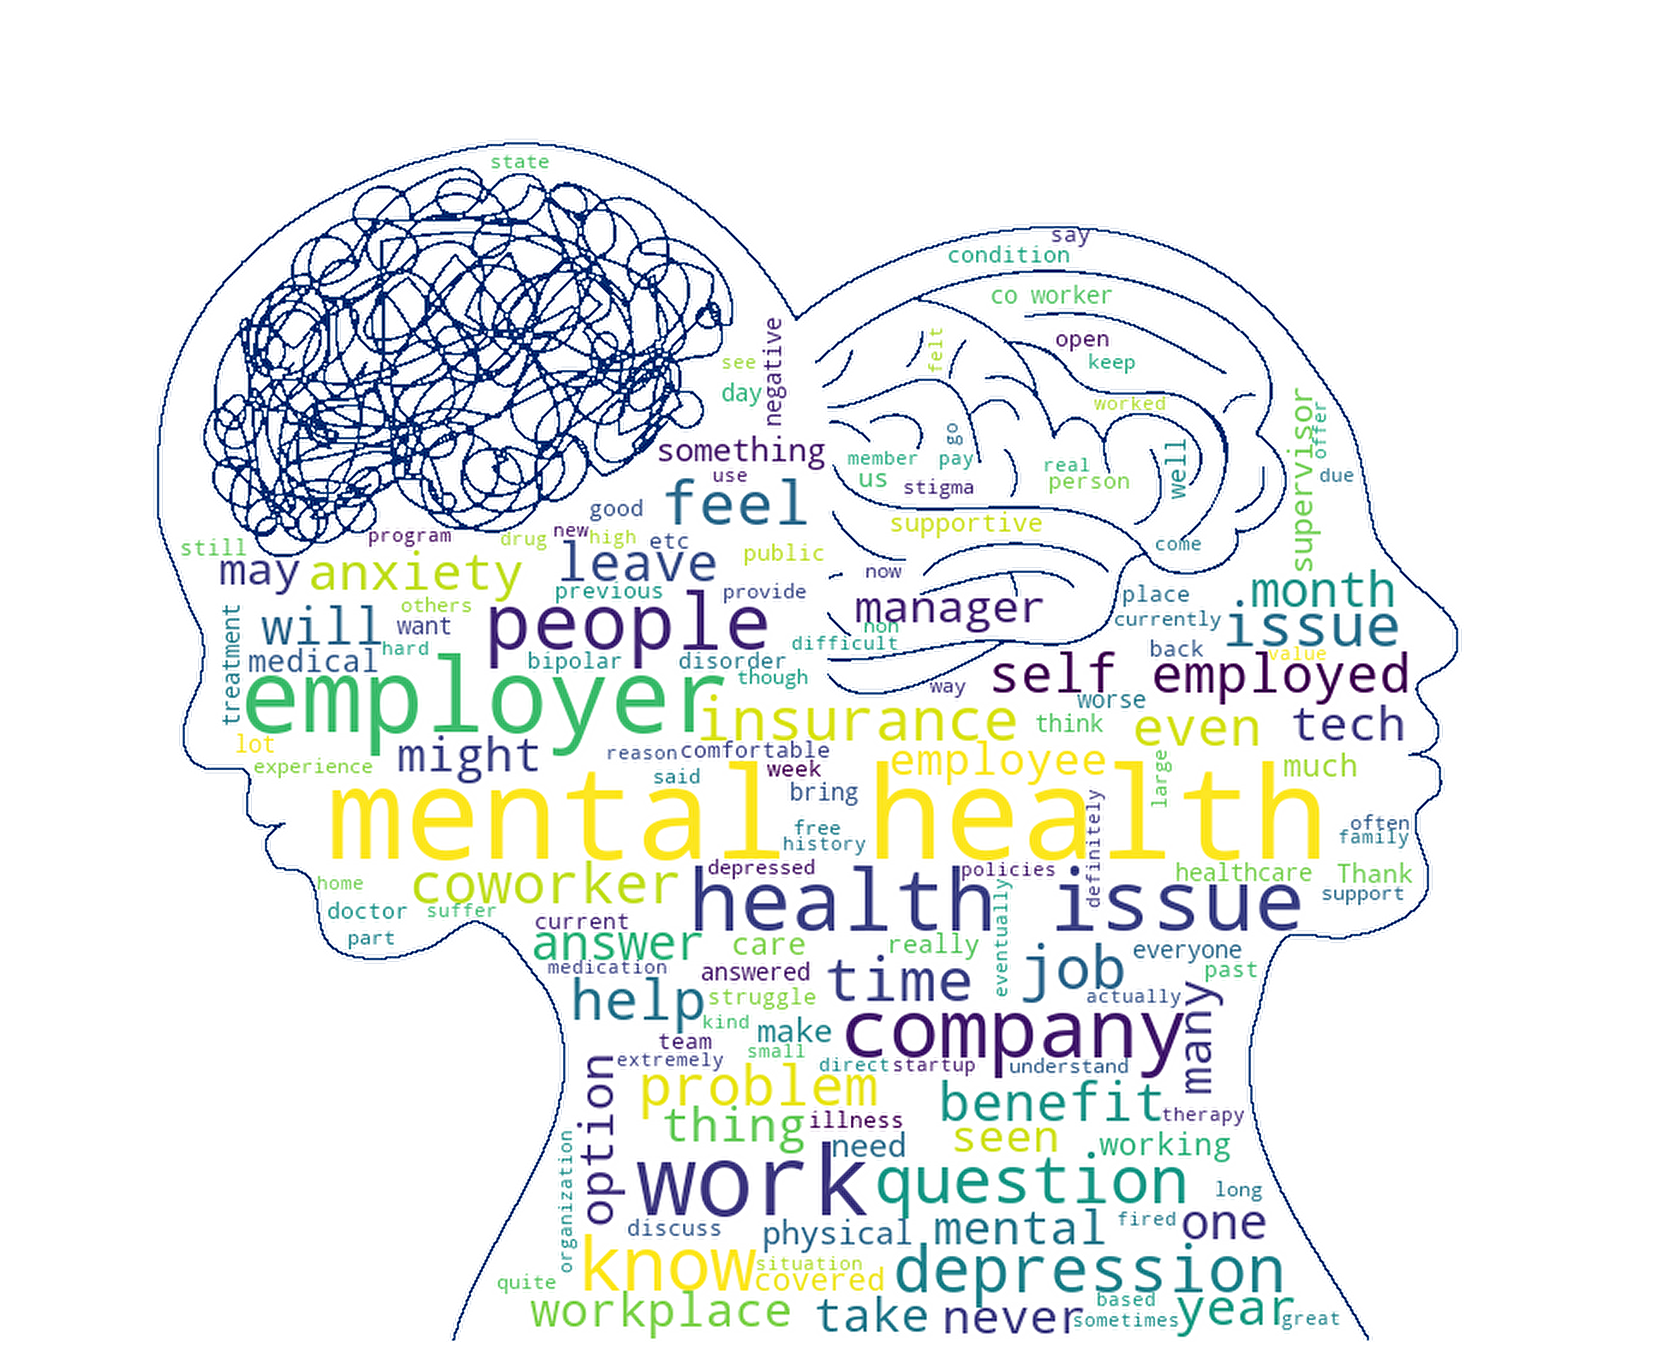

In [148]:
mask = np.array(Image.open("image.png"))

words = ''.join(mental2014['comments'].dropna())


plt.figure(figsize=(14,14), dpi=150)

wordcloud = WordCloud(max_words=150,
                       stopwords = STOPWORDS,
                       background_color = "white",
                       contour_color='#023075',
                       mask = mask,
                       contour_width=1,
                       width=1500, height=800).generate(words)

plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")

plt.show()

In [149]:
# we will remove the column "comments" from the 2014 Dataset
mental2014 = mental2014.drop(columns='comments')

[TOP](#top)
<a id='work_interfere'></a>
#### column "work_interfere"
we can see the difference here:<br>
in 2014: the question is 'If you have a mental health condition, do you feel that it interferes with your work?'<br>
while in 2016 this question gets split and is interested what would be the difference if any issues are medically treated.<br>
This condition could make significant impact on the answer, and whatever we decide to do to merge the data from 2014 and 2016, it will bring noise and error to the results.<br>
We can of course process the data from 2014 and 2016 independently, but right now we will assume that the answer in 2014 would be the same with or without  treatment.

In [150]:
mental2014['work_treatment_interfere'] = mental2014['work_interfere']
mental2014['work_no_treatment_interfere'] = mental2014['work_interfere']
mental2014 = mental2014.drop(columns='work_interfere')

[TOP](#top)
<a id='merge'></a>
### Merging the Datasets together

In [151]:
#columns in 2014 that are not in 2016 after our work
set(mental2014.columns) - set(mental2016.columns)

set()

In [152]:
# this will clear all teh columns in 2016 that are missing in 2014 so that we can merge them together
mental2016 = mental2016[mental2014.columns]

In [153]:
#merging the two datasets together
al_mental = pd.concat([mental2014,mental2016], ignore_index=True)

[TOP](#top)
<a id='quality'></a>

### Quality of data
Now we will check where we have missing, incorrect or duplicate values and will try to fix them.<br>

In [154]:
al_mental.info() # it is a good news tha tthe Age is int64, meaning that we have only numbers there

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2693 entries, 0 to 2692
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          2693 non-null   int64 
 1   Gender                       2690 non-null   object
 2   Country                      2693 non-null   object
 3   state                        1584 non-null   object
 4   self_employed                2675 non-null   object
 5   family_history               2693 non-null   object
 6   treatment                    2693 non-null   object
 7   no_employees                 2406 non-null   object
 8   remote_work                  2693 non-null   object
 9   tech_company                 2406 non-null   object
 10  benefits                     2406 non-null   object
 11  care_options                 2273 non-null   object
 12  wellness_program             2406 non-null   object
 13  seek_help                    2406

In [155]:
al_mental.describe() # yet we see that we have negative values in the Age column and also some very hign values.

,Age,year
count,2.693000e+03,2693.000000
mean,3.713334e+07,2015.064241
std,1.927000e+09,0.998120
min,-1.726000e+03,2014.000000
25%,2.800000e+01,2014.000000
50%,3.200000e+01,2016.000000
75%,3.700000e+01,2016.000000
max,1.000000e+11,2016.000000


[TOP](#top)
<a id='unique'></a>
#### Unique Table

We will focus on "Age", "state" and "treatment" <br>
[Unique Values in remote_work](#remote_w)<br>
[Unique Values in Age](#age)<br>
[Unique Values in state](#state)<br>
[Unique Values in Country](#country)<br>
[Unique Values in treatment](#treatment)<br>


In [156]:
for i in al_mental.columns :
    print('Unique values for "{}"'.format(i))
    print(al_mental[i].unique())
    print('---------------------------------------------------------------------------------')

Unique values for "Age"
[         37          44          32          31          33          35
          39          42          23          29          36          27
          46          41          34          30          40          38
          50          24          18          28          26          22
          19          25          45          21         -29          43
          56          60          54         329          55 99999999999
          48          20          57          58          47          62
          51          65          49       -1726           5          53
          61           8          11          -1          72          52
          17          63          99         323           3          66
          59          15          74          70]
---------------------------------------------------------------------------------
Unique values for "Gender"
['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female

[Unique Table](#unique)
<a id='remote_w'></a>
####  Unique Values in remote_work
The survey from 2014 had only options "Yes" and "No" while in 2016: 'Sometimes' 'Never' 'Always'.<br>

In [157]:
# We will replace Yes with Sometimes and No with Never. As most of the positive answers are "Sometimes"
al_mental.groupby(by = 'remote_work').size()

remote_work
Always       343
Never        333
No           884
Sometimes    757
Yes          376
dtype: int64

In [158]:
al_mental['remote_work'] = al_mental['remote_work'].replace({"Yes" : "Sometimes", "No" : "Never"})

[Unique Table](#unique)
<a id='age'></a>
####  Unique Values in Age
Lets see how are the ages distributed

In [159]:
np.sort(al_mental.Age.unique())

array([      -1726,         -29,          -1,           3,           5,
                 8,          11,          15,          17,          18,
                19,          20,          21,          22,          23,
                24,          25,          26,          27,          28,
                29,          30,          31,          32,          33,
                34,          35,          36,          37,          38,
                39,          40,          41,          42,          43,
                44,          45,          46,          47,          48,
                49,          50,          51,          52,          53,
                54,          55,          56,          57,          58,
                59,          60,          61,          62,          63,
                65,          66,          70,          72,          74,
                99,         323,         329, 99999999999], dtype=int64)

There are some outliers that for sure needs to be removed. As this is a study focused on working people we will set a minimum of 18 years and a maximum of 70. It is visible from the chart bellow that those 

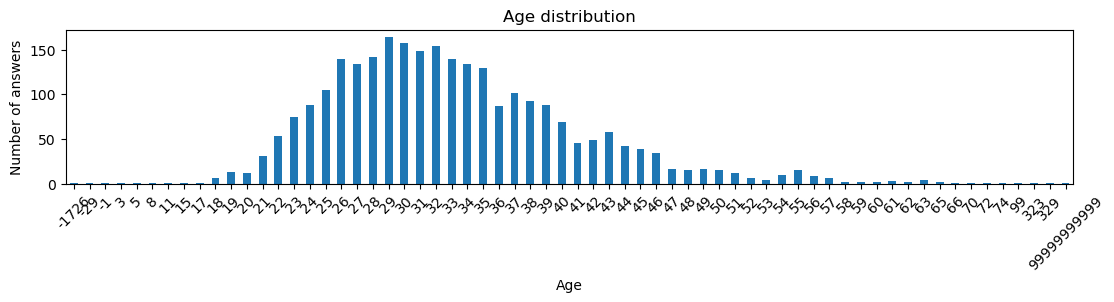

In [160]:
plt.figure(figsize=(13, 2))
al_mental['Age'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Age')
plt.xticks(rotation = 45)
plt.ylabel('Number of answers')
plt.title('Age distribution')
plt.show()

In [161]:
len(al_mental[(al_mental.Age < 18) | (al_mental.Age > 70)]) 
#as the number of those outliers is just 15 we will drop them from the dataset

15

In [162]:
al_mental = al_mental[(al_mental.Age >= 18) & (al_mental.Age <= 70)]

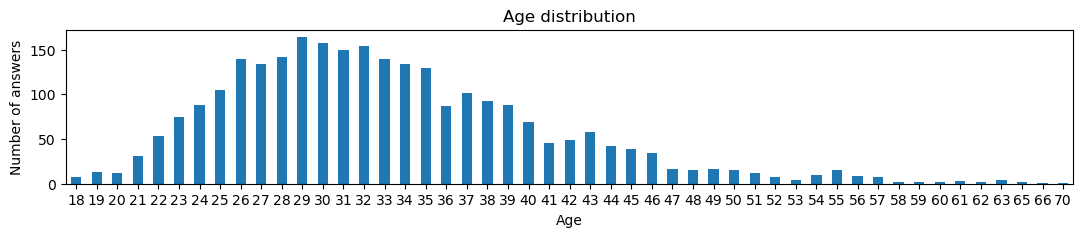

In [163]:
plt.figure(figsize=(13, 2))
al_mental['Age'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Age')
plt.xticks(rotation = 0)
plt.ylabel('Number of answers')
plt.title('Age distribution')
plt.show()

[Unique Table](#unique)
<a id='state'></a>
#### Unique Values in state

We will only change the state names to their abbreviations. The NaN values will stay as the survey is international

In [164]:
al_mental.state.unique()

array(['IL', 'IN', nan, 'TX', 'TN', 'MI', 'OH', 'CA', 'CT', 'MD', 'NY',
       'NC', 'MA', 'IA', 'PA', 'WA', 'WI', 'UT', 'NM', 'OR', 'FL', 'MN',
       'MO', 'AZ', 'CO', 'GA', 'DC', 'NE', 'WV', 'OK', 'KS', 'VA', 'NH',
       'KY', 'AL', 'NV', 'NJ', 'SC', 'VT', 'SD', 'ID', 'MS', 'RI', 'WY',
       'LA', 'ME', 'Illinois', 'Tennessee', 'Virginia', 'California',
       'Kentucky', 'Oregon', 'Pennsylvania', 'New Jersey', 'Georgia',
       'Washington', 'New York', 'Indiana', 'Minnesota', 'West Virginia',
       'Florida', 'Massachusetts', 'North Dakota', 'Texas', 'Maryland',
       'Wisconsin', 'Michigan', 'Vermont', 'North Carolina', 'Kansas',
       'District of Columbia', 'Nevada', 'Utah', 'Connecticut',
       'Colorado', 'Ohio', 'Iowa', 'South Dakota', 'Nebraska', 'Maine',
       'Missouri', 'Arizona', 'Oklahoma', 'Idaho', 'Rhode Island',
       'Alabama', 'Louisiana', 'South Carolina', 'New Hampshire',
       'New Mexico', 'Montana', 'Alaska', 'Delaware'], dtype=object)

In [165]:
us_state_to_abbrev = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 
                      'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 
                      'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 
                      'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 
                      'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 
                      'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 
                      'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 
                      'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 
                      'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 
                      'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', 
                      'District of Columbia': 'DC', 'American Samoa': 'AS', 'Guam': 'GU', 'Northern Mariana Islands': 'MP', 
                      'Puerto Rico': 'PR', 'United States Minor Outlying Islands': 'UM', 'U.S. Virgin Islands': 'VI'}

In [166]:
al_mental['state'] = al_mental['state'].replace(us_state_to_abbrev)
al_mental.state.unique()

array(['IL', 'IN', nan, 'TX', 'TN', 'MI', 'OH', 'CA', 'CT', 'MD', 'NY',
       'NC', 'MA', 'IA', 'PA', 'WA', 'WI', 'UT', 'NM', 'OR', 'FL', 'MN',
       'MO', 'AZ', 'CO', 'GA', 'DC', 'NE', 'WV', 'OK', 'KS', 'VA', 'NH',
       'KY', 'AL', 'NV', 'NJ', 'SC', 'VT', 'SD', 'ID', 'MS', 'RI', 'WY',
       'LA', 'ME', 'ND', 'MT', 'AK', 'DE'], dtype=object)

In [167]:
al_mental[(~al_mental.Country.isin(['United States', 'United States of America'])) & 
                           (al_mental.state.isna() == False)]

,Age,Gender,Country,state,self_employed,family_history,treatment,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,year,work_treatment_interfere,work_no_treatment_interfere
319,29,male,Latvia,NY,No,No,No,26-100,Never,Yes,No,Yes,No,No,Don't know,Somewhat easy,Maybe,Maybe,Some of them,Some of them,No,No,Don't know,No,2014,NaN,NaN
488,26,Male,Israel,MD,No,No,No,6-25,Never,Yes,No,No,No,No,Yes,Very easy,Maybe,No,Some of them,Yes,No,Maybe,Yes,No,2014,Sometimes,Sometimes
1179,25,female,Bulgaria,UT,No,No,Yes,26-100,Sometimes,Yes,No,No,No,No,Don't know,Don't know,Maybe,Maybe,Yes,Some of them,Maybe,No,No,No,2014,Sometimes,Sometimes


In [168]:
# lets doublecheck that there are no State entries outside of US
wrong_st_index = al_mental[(~al_mental.Country.isin(['United States', 'United States of America'])) & 
                           (al_mental.state.isna() == False)].index.tolist()

In [169]:
# we will have to set those states to NaN
al_mental.loc[wrong_st_index,'state'] = np.nan
al_mental.loc[wrong_st_index]

,Age,Gender,Country,state,self_employed,family_history,treatment,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,year,work_treatment_interfere,work_no_treatment_interfere
319,29,male,Latvia,NaN,No,No,No,26-100,Never,Yes,No,Yes,No,No,Don't know,Somewhat easy,Maybe,Maybe,Some of them,Some of them,No,No,Don't know,No,2014,NaN,NaN
488,26,Male,Israel,NaN,No,No,No,6-25,Never,Yes,No,No,No,No,Yes,Very easy,Maybe,No,Some of them,Yes,No,Maybe,Yes,No,2014,Sometimes,Sometimes
1179,25,female,Bulgaria,NaN,No,No,Yes,26-100,Sometimes,Yes,No,No,No,No,Don't know,Don't know,Maybe,Maybe,Yes,Some of them,Maybe,No,No,No,2014,Sometimes,Sometimes


[Unique Table](#unique)
<a id='country'></a>
#### Unique Values in Country
We see that the States were listed with full name and with abbreviation, lets have a look at the countries 

In [170]:
country_list = al_mental.Country.unique().tolist()
country_list.sort()
country_list

['Afghanistan',
 'Algeria',
 'Argentina',
 'Australia',
 'Austria',
 'Bangladesh',
 'Belgium',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Ecuador',
 'Estonia',
 'Finland',
 'France',
 'Georgia',
 'Germany',
 'Greece',
 'Guatemala',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Latvia',
 'Lithuania',
 'Mexico',
 'Moldova',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'Norway',
 'Other',
 'Pakistan',
 'Philippines',
 'Poland',
 'Portugal',
 'Romania',
 'Russia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'United Kingdom',
 'United States',
 'United States of America',
 'Uruguay',
 'Venezuela',
 'Vietnam']

We see that the United States and United States of America are both present. We will change this but lets try to make our computer help us here instead of reading them all.<br>
we will use [FuzzyWuzzy Library](https://pypi.org/project/fuzzywuzzy/)

In [171]:
for i in range(len(country_list)):
    for j in range(i+1, len(country_list)):
        if fuzz.partial_ratio(country_list[i],country_list[j]) > 80:
            print(f'"{country_list[i]}" and "{country_list[j]}" are very similar and should be checked')

"Australia" and "Austria" are very similar and should be checked
"United States" and "United States of America" are very similar and should be checked


In [172]:
# we will replace "United States of America"  with "United States"
al_mental.Country.replace({"United States of America":"United States"}, inplace= True)

[Unique Table](#unique)
<a id='treatment'></a>
####  Unique Values in treatment

We will replace Yes with 1 and No with 0

In [173]:
al_mental.treatment.unique()

array(['Yes', 'No', 0, 1], dtype=object)

In [174]:
al_mental['treatment'] = al_mental['treatment'].replace({"Yes" : 1, "No" : 0})

[TOP](#top)
<a id='clear'></a>
#### NaN table

In [175]:
al_mental.isna().sum() 
# there are a few empty fields that we will investigate

Age                               0
Gender                            3
Country                           0
state                          1107
self_employed                    18
family_history                    0
treatment                         0
no_employees                    286
remote_work                       0
tech_company                    286
benefits                        286
care_options                    418
wellness_program                286
seek_help                       286
anonymity                       286
leave                           286
mental_health_consequence       286
phys_health_consequence         286
coworkers                       286
supervisor                      286
mental_health_interview           0
phys_health_interview             0
mental_vs_physical              286
obs_consequence                 286
year                              0
work_treatment_interfere        262
work_no_treatment_interfere     262
dtype: int64


We will focus on each of this columns in our work bellow:<br>
[Gender NaN](#gender)<br>
[self_employed NaN](#self)<br>
[benefits and others NaN](#benefit)<br>
[obs_consequence NaN](#obs)<br>
[no_employees NaN](#no_em)<br>
[tech_company NaN](#tech)<br>
[work_treatment_interfere / work_no_treatment_interfere NaN](#treat)<br>
[Check of the data](#check)

[NaN Table](#clear)
<a id='gender'></a>
####  Gender  NaN

Here we should be more careful as this field is important and can affect the mental health of the individual. This question is open and we will have to analyze the answers and group them.<br>
First we will drop the NaN entries as they are only 3 ([NaN table](#clear))


In [176]:
al_mental.dropna(subset=['Gender'], inplace=True)
#Dropping the rows of the missing Sex identity 

In [177]:
al_mental.Gender.unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'Enby', 'fluid',
       'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'Malr', 'femail',
       'Cis Man', 'ostensibly male, unsure what that really means',
       'I identify as female.', 'female ', 'Bigender',
       'Female assigned at birth ', 'man', 'fm', 'Cis female ',
       'Transitioned, M2F', 'Genderfluid (born female)',
       'Other/Transfeminine', 'Female or Multi-Gender Femme',
       'female/woman', 'Cis male', 'Male.', 'Androgynous',
       'male 9:1 female, roughly', 'Male (cis)', 'nb masculine',
       'Cis

Even though some people have taken the opportunity of the open field beyond the necessary, the data is not too much and will be able to fix it manually. I will provide a short description of some of the terms:<br>
* CIS : Cis, short for cisgender (pronounced sis-gender, or just sis), is a term that means whatever gender you are now is the same as what was presumed for you at birth.<br>
* Androgynous : partly male and partly female in appearance; of indeterminate sex
* Trans-gender women, sometimes called male-to-female (MtF), are those who were assigned the male sex at birth (AMAB), but who identify and live as women
* Trans men who transition are commonly referred to as female-to-male (FTM or F2M).  trans man is a man who was assigned female at birth.
* Queer/Gay is an umbrella term for people who are not heterosexual or are not cisgender. Originally meaning 'strange' or 'peculiar', queer came to be used pejoratively against those with same-sex desires or relationships in the late 19th century.
* Non-binary (Enby, ) and genderqueer are umbrella terms for gender identities that are not solely male or female
* Fluid is a form of gender identity or gender expression, rather than a sexual orientation. Fluid relates to how a person identifies themselves internally and presents themselves to the world. A person who is gender fluid may identify as male one day, female the next, both male and female, or neither.
* Agender (adj.) is not having a gender or a “lack of” a gender.
* etc....

in our analysis we will use 3 categories of Gender:<br> 
F = female<br>
M = male<br>
other = others

In [178]:
al_mental.Gender = al_mental.Gender.str.lower() # set all letters to lowecase so that it is easier to filter

trans_gender_list = ['binary','trans','fluid', 'queer', 'enby', 'androgyne', 
                     'agender', 'neuter', 'bigender','mtf', 'androgynous','nah','unicorn', 'flux']

for g in trans_gender_list:
    al_mental.loc[al_mental['Gender'].str.contains(g), 'Gender'] = 'other'

Due to the way the "contains" works i have decided to first filter all "other" categories as we have transmale and transfemale and other similar entries. The "other" category actually took some time and there is whole [wiki](https://gender.fandom.com/wiki/Gender_Wiki) page where you can find more if this is something, the reader is curious about.<br>
Then I filter all "F" as male is part of the word female i don't want create confusion here

In [179]:
female_gender_list = ['female','femail','fm','woman','girl','afab','fem']

for g in female_gender_list:
    al_mental.loc[al_mental['Gender'].str.contains(g), 'Gender'] = 'f'

In [180]:
male_gender_list = ['male', 'maile', 'cis male', 'mal','make','guy', 'man',
                   'msle', 'mail', 'malr', 'masculine','m\|','dude']

for g in male_gender_list:
    al_mental.loc[al_mental['Gender'].str.contains(g), 'Gender'] = 'm'

In [181]:
al_mental.Gender.unique() 
# we can see that we have a good progress
# there is only one entry that doesnt want to share its gender, and we will drop it from the dataset

array(['f', 'm', 'other', 'none of your business'], dtype=object)

In [182]:
al_mental = al_mental.drop(index= al_mental[al_mental['Gender'] == 'none of your business'].index)
#droping the "none of your business" entry

In [183]:
al_mental.Gender.unique()

array(['f', 'm', 'other'], dtype=object)

[NaN Table](#clear)
<a id='self'></a>
####  self_employed   NaN

We have 18 NaN entries here. Based on how the question was asked 'Are you self-employed?' , it would make sense assuming no answer means that they are not self-employed. Yet lets look in to the details for this observations.
From the table bellow we see most of them are part of a big organization (>26). Based on this I will assume that those observations are not self employed (understanding that this might not be correct).

In [184]:
al_mental[al_mental.self_employed.isna()].iloc[:,4:18]

,self_employed,family_history,treatment,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence
0,NaN,No,1,6-25,Never,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No
1,NaN,No,0,More than 1000,Never,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No
2,NaN,No,0,6-25,Never,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No
3,NaN,Yes,1,26-100,Never,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes
4,NaN,No,0,100-500,Sometimes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No
5,NaN,Yes,0,6-25,Never,Yes,Yes,Not sure,No,Don't know,Don't know,Don't know,No,No
6,NaN,Yes,1,1-5,Sometimes,Yes,No,No,No,No,No,Somewhat difficult,Maybe,Maybe
7,NaN,No,0,1-5,Sometimes,Yes,No,Yes,No,No,Yes,Don't know,No,No
8,NaN,Yes,1,100-500,Never,Yes,Yes,Yes,No,No,No,Very difficult,Maybe,No
9,NaN,No,0,26-100,Never,Yes,Don't know,No,Don't know,Don't know,Don't know,Don't know,No,No


In [185]:
al_mental.self_employed.fillna(0, inplace=True)
#replacing NaN with 0

In [186]:
al_mental.self_employed.unique()
# we can see that we have different answers here and I will replace 1 with Yes and 0 with No

array([0, 'Yes', 'No', 1], dtype=object)

In [187]:
al_mental['self_employed'] = al_mental['self_employed'].replace({1 : 'Yes', 0 : 'No'})
al_mental.self_employed.unique()

array(['No', 'Yes'], dtype=object)

[NaN Table](#clear)
<a id='benefit'></a>
####  benefit   NaN

There is a very interesting pattern that there are exactly 287 NaN entries for the following columns ([NaN Table](#clear)):<br>
no_employees                    
tech_company                    
benefits                        
wellness_program                
seek_help                       
anonymity                       
leave                           
mental_health_consequence    
phys_health_consequence   
coworkers    
supervisor     
mental_vs_physical      
obs_consequence                 

those are all characteristics of the employer. Maybe those are some self employed observations. <br>
Due to the activities before those NaN entries have declined to 286 as obviously we have cleaned one of them due the reasons given above. 
Lets first check if those 286 NaN in no_employees are the same in all other columns.

Here we will handle the following columns:<br>
'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_vs_physical'

In [188]:
al_mental[al_mental.benefits.isna()].isna().sum()
#filter the observation with no_employees == NaN and see where else have those individuals answered with NaN

Age                              0
Gender                           0
Country                          0
state                          155
self_employed                    0
family_history                   0
treatment                        0
no_employees                   286
remote_work                      0
tech_company                   286
benefits                       286
care_options                   286
wellness_program               286
seek_help                      286
anonymity                      286
leave                          286
mental_health_consequence      286
phys_health_consequence        286
coworkers                      286
supervisor                     286
mental_health_interview          0
phys_health_interview            0
mental_vs_physical             286
obs_consequence                286
year                             0
work_treatment_interfere         0
work_no_treatment_interfere      0
dtype: int64

It gets clear that they overlap. Thus it is very possible that they are self employed. Lets check

In [189]:
list_of_benefits_togetfilled = al_mental[al_mental['benefits'].isna()].self_employed.index
len(list_of_benefits_togetfilled)
# list of the indexes of those 286 observations

286

In [190]:
al_mental.loc[list_of_benefits_togetfilled].self_employed.unique()
# we can confirm all of them are self employed
# This is another confirmation that the self employed individuals found it hard to populate the survey. 
# This a conclusion we made from the "Comments" section, when we were Loading the datasets

array(['Yes'], dtype=object)

In [191]:
# Let us check from which year are those answers
al_mental.loc[list_of_benefits_togetfilled].year.unique()

array([2016], dtype=int64)

In [192]:
# I will make a list of those 14 columns and will see what aswers do we have there
list_nan_answ = ['no_employees','tech_company','benefits','care_options','wellness_program','seek_help','anonymity',
'leave','mental_health_consequence','phys_health_consequence','coworkers','supervisor','mental_vs_physical',
'obs_consequence']

for i in list_nan_answ :
    print('Unique values for "{}"'.format(i))
    print(al_mental[i].unique())
    print('---------------------------------------------------------------------------------\n')

Unique values for "no_employees"
['6-25' 'More than 1000' '26-100' '100-500' '1-5' '500-1000' nan]
---------------------------------------------------------------------------------

Unique values for "tech_company"
['Yes' 'No' 1.0 nan 0.0]
---------------------------------------------------------------------------------

Unique values for "benefits"
['Yes' "Don't know" 'No' 'Not eligible for coverage / N/A' nan
 "I don't know"]
---------------------------------------------------------------------------------

Unique values for "care_options"
['Not sure' 'No' 'Yes' nan 'I am not sure']
---------------------------------------------------------------------------------

Unique values for "wellness_program"
['No' "Don't know" 'Yes' nan "I don't know"]
---------------------------------------------------------------------------------

Unique values for "seek_help"
['Yes' "Don't know" 'No' nan "I don't know"]
---------------------------------------------------------------------------------

Un

<a id='my_noice1'></a>
Many of those questions could be answered with "Maybe", "I don't know", "Don't know", 'Not sure', 'I am not sure'.<br>
1/ We will change "I don't know" to "Don't know" and 'I am not sure' to 'Not sure'<br>
2/ in every column that we have "Maybe" or "Don't know" we will use those values to replace the NaN values<br>
3/ We will also fix tech_company to show only 1 for yes and 0 for No<br>
The columns are:

In [193]:
# Column tech_company
al_mental['tech_company'] = al_mental['tech_company'].replace({"Yes" : 1, "No" : 0})


# Column care_options
al_mental.care_options.fillna('Not sure', inplace = True)
al_mental['care_options'] = al_mental['care_options'].replace({'I am not sure' : 'Not sure'})

# Column benefits, seek_help, anonymity, leave, wellness_program, mental_vs_physical
for i in ['benefits', 'seek_help', 'anonymity', 'leave', 'wellness_program', 'mental_vs_physical']:
    al_mental[i].fillna("Don't know", inplace = True)
    al_mental[i] = al_mental[i].replace({"I don't know" : "Don't know"})

# Column mental_health_consequence, phys_health_consequence, coworkers, supervisor
for i in ['mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor']:
    al_mental[i].fillna('Maybe', inplace = True)



Now we have to decide what to do with the NaN values in <b> no_employees, tech_company, obs_consequence </b><br>
All of the NaN observations are self employed. Let see how many of the self employed work in the tech industry:

[NaN Table](#clear)
<a id='obs'></a>
####  obs_consequence   NaN
We can see bellow that most of the people did not observe negative consequence for a colleague.
We will assume that if this field is empty then the participant did not observe such!
we will also replace Yes to 1 and No to 0

In [194]:
al_mental.obs_consequence.value_counts()

obs_consequence
No     2113
Yes     275
Name: count, dtype: int64

In [195]:
al_mental['obs_consequence'] = al_mental['obs_consequence'].replace({"Yes" : 1, "No" : 0})
al_mental.obs_consequence.fillna(0, inplace= True)

[NaN Table](#clear)
<a id='no_em'></a>
####  no_employees   NaN


This field is not so easy to fill. The cells bellow will show that even though all of our 286 observations are Self-employed : <br>

In [196]:
# all of them are self employed
al_mental[al_mental.no_employees.isna()].self_employed.value_counts()

self_employed
Yes    286
Name: count, dtype: int64

In [197]:
# they don't necessary work remotely all the time (meaning some of them visit Office)
al_mental[al_mental.no_employees.isna()].remote_work.value_counts()

remote_work
Sometimes    145
Always       126
Never         15
Name: count, dtype: int64

In [198]:
# all that have skipped this question are from 2016
al_mental[al_mental.no_employees.isna()].year.unique()

array([2016], dtype=int64)

In [199]:
# it is clear that from teh 2014 survey there were self employed participants who gave an answer to this question
al_mental[al_mental.self_employed == 1].no_employees.value_counts()

Series([], Name: count, dtype: int64)

In [200]:
# it is important to get those participants answers. We don't really want to know much about their Employer. 
# While reading the "Comments" column from 2014 it got clear that selfemployed people were confused 
# how to answer to those questions
al_mental[al_mental.self_employed == 1].year.value_counts() # Number of self employed per year

Series([], Name: count, dtype: int64)

In [201]:
print('Those missing values are {:.2f}% of our combined Dataset'.format(len(al_mental[al_mental.no_employees.isna()])/len(al_mental)*100))

Those missing values are 10.70% of our combined Dataset


Based on the Above we can:<br>
1. Use a Regression model that will learn from 2014 and will populate the data from 2016 (bad idea as we have too little self employed from 2014)
2. Use the proportion from 2014 and assign values for the observations from 2016 according to this proportion on random (this just sounds wrong)
3. As those people are self employed we can assume and assign a value of "1-5" as number of Employees (yet they are around 10% of our dataset and this can bring too much error/noise) 
4. Leave them NaN
**5. After more careful analysis of the questions from 2016, we see pattern (this analysis is not in the project) that suggest that OSMI were using conditional Questions display. this would mean that people who answered that they are self employed  were not asked to provide information for the employer. This is backed up by the comments from 2014, and if OSMI have taken that feedback and decided to skip this questions for the self employed that would explain it all.***

If we decide to go with option "5." then the best solution would be to edit the data from 2014 and make those features as NaN for the self employed, this way syncing the data!


yet for now we will go with option "3."

In [202]:
al_mental.no_employees.fillna("1-5", inplace = True)

[NaN Table](#clear)
<a id='tech'></a>
####  tech_company   NaN

Similar to the no_employees case we can use pretty much the same 5 approaches.

Again I will choose "3." and in this case will assume all of the self employed in 2016 work in the Tech.

In [203]:
al_mental[al_mental.self_employed == 1].tech_company.value_counts()
#almost all of teh self employed in 2014 were in a Tech company

Series([], Name: count, dtype: int64)

In [204]:
al_mental.tech_company.fillna(1, inplace = True)

[NaN Table](#clear)
<a id='treat'></a>
####  work_treatment_interfere / work_no_treatment_interfere NaN

Lets check if the same observation are responsible for those empty fields

In [205]:
# check if thе same indexes in work_treatment_interfere and work_no_treatment_interfere are NaN
all(al_mental[al_mental.work_treatment_interfere.isna()].index == al_mental[al_mental.work_no_treatment_interfere.isna()].index) == True

True

In [206]:
# all of those entries are comming from 2014
al_mental[al_mental.work_treatment_interfere.isna()].year.value_counts()

year
2014    262
Name: count, dtype: int64

In [207]:
#possible answers to this questions are 
display(al_mental.work_no_treatment_interfere.unique())
al_mental.work_treatment_interfere.unique()

array(['Often', 'Rarely', 'Never', 'Sometimes', nan,
       'Not applicable to me'], dtype=object)

array(['Often', 'Rarely', 'Never', 'Sometimes', nan,
       'Not applicable to me'], dtype=object)

We have the option 'Not applicable to me' which is the closes one to not wanting to answer.

In [208]:
print('People who answered "Not applicable to me" for work_treatment_interfere: {}'.format(
    len(al_mental[al_mental.work_treatment_interfere == 'Not applicable to me'])))
print('People who answered "Not applicable to me" for work_no_treatment_interfere: {}'.format(
    len(al_mental[al_mental.work_no_treatment_interfere == 'Not applicable to me'])))
print('People who answered "Not applicable to me" for work_no_treatment_interfere and work_treatment_interfere: {}'.format(
    len(al_mental[(al_mental.work_no_treatment_interfere == 'Not applicable to me') & 
                (al_mental.work_treatment_interfere == 'Not applicable to me')])))

People who answered "Not applicable to me" for work_treatment_interfere: 554
People who answered "Not applicable to me" for work_no_treatment_interfere: 466
People who answered "Not applicable to me" for work_no_treatment_interfere and work_treatment_interfere: 450


We can see above that most people who answered 'Not applicable to me' to the first question have answered this way to the second

In [209]:
#thus I replase them accordingly
al_mental.work_treatment_interfere.fillna('Not applicable to me', inplace = True)
al_mental.work_no_treatment_interfere.fillna('Not applicable to me', inplace = True)

[NaN Table](#clear)
<a id='check'></a>
####  Check of the data

In [210]:
# Now we have no unnecessary NaN values with the exception of teh "state" feature
al_mental.isna().sum() 

Age                               0
Gender                            0
Country                           0
state                          1106
self_employed                     0
family_history                    0
treatment                         0
no_employees                      0
remote_work                       0
tech_company                      0
benefits                          0
care_options                      0
wellness_program                  0
seek_help                         0
anonymity                         0
leave                             0
mental_health_consequence         0
phys_health_consequence           0
coworkers                         0
supervisor                        0
mental_health_interview           0
phys_health_interview             0
mental_vs_physical                0
obs_consequence                   0
year                              0
work_treatment_interfere          0
work_no_treatment_interfere       0
dtype: int64

In [211]:
for i in al_mental.columns :
    print('Unique values for "{}"'.format(i))
    print(al_mental[i].unique())
    print('---------------------------------------------------------------------------------')

Unique values for "Age"
[37 44 32 31 33 35 39 42 23 29 36 27 46 41 34 30 40 38 50 24 18 28 26 22
 19 25 45 21 43 56 60 54 55 48 20 57 58 47 62 51 65 49 53 61 52 63 66 59
 70]
---------------------------------------------------------------------------------
Unique values for "Gender"
['f' 'm' 'other']
---------------------------------------------------------------------------------
Unique values for "Country"
['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Greece' 'Moldova' 'Georgia'
 'China' 'Czech Republic' 'Philippines' 'Lithuania' 'Venezuela'
 'Argentina' 'Vietnam' 'Slovakia' 'Bangladesh' 'A

[TOP](#top)
<a id='fe'></a>
## Feature Engineering

I want to know which participants seek treatment, and what feature affect this the most. I will also try build a model predicting who would not seek treatment but is in risk.


In [212]:
#we will first reset the indexes so we can start fresh
al_mental = al_mental.reset_index(drop = True)

[TOP](#top)
<a id='state_e'></a>
#### Country and State to Continent

State is a valid column only for the United States

In [213]:
print(f'{len(al_mental[al_mental.Country == "United States"])*100/len(al_mental):.2f}% of the participants are from the United States.')

59.05% of the participants are from the United States.


In [214]:
most_frequent_state = al_mental[al_mental.Country == 'United States'].state.value_counts().idxmax()

In [215]:
print(f'We have {len(al_mental[(al_mental.Country == "United States")  & (al_mental.state.isna() == True)])} missing values')
print(f'Which we will fill with the most common state: "{most_frequent_state}"')
al_mental.loc[al_mental['Country'] == 'United States', 'state'] = al_mental.loc[
    al_mental['Country'] == 'United States', 'state'].fillna(most_frequent_state)

al_mental[al_mental['Country'] == 'United States'].state.isna().sum()

We have 11 missing values
Which we will fill with the most common state: "CA"


0

The dataset is imbalanced as we have many participants form the Unites States 59 %
Let see which countries have more than 5 participants and also the countries with <= to 5 participants<br>
<b>The number 5 is not randomly selected, i have seen this threshold before and based on the following Note from ["scipy.stats.chi2_contingency" documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#rf346382074c5-4):</b><br>
    "An often quoted guideline for the validity of this calculation is that the test should be used only if the observed and expected frequencies in each cell are at least 5."

In [216]:
more_5 = al_mental.groupby(by = 'Country').size().loc[lambda x: x>=5]
less_5 = al_mental.groupby(by = 'Country').size().loc[lambda x: x<5]
more_5 = more_5.sort_values(ascending= True)
less_5 = less_5.sort_values(ascending= True)

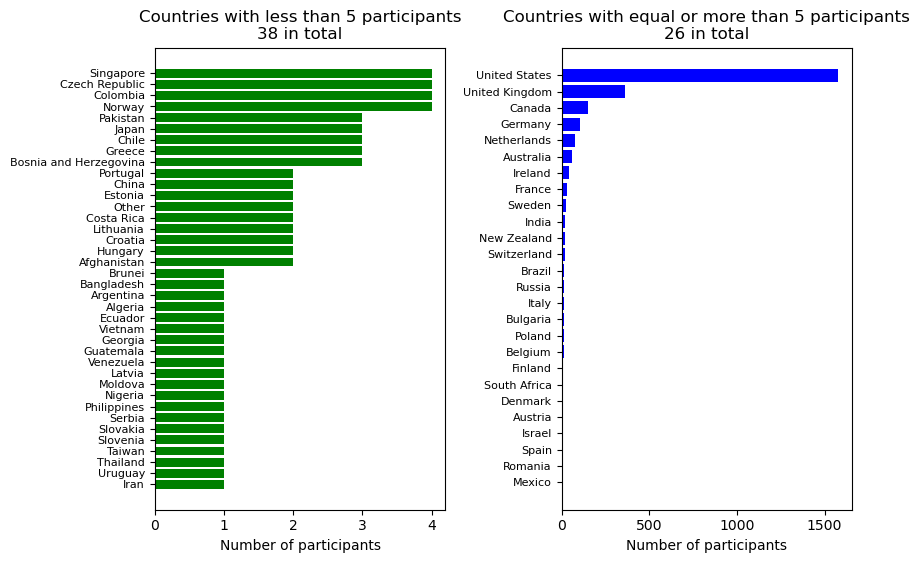

In [217]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
plt.subplots_adjust(wspace=0.4)
axes[0].barh(less_5.index, less_5, color = 'green')
axes[0].set_title(f'Countries with less than 5 participants\n{len(less_5)} in total')
axes[0].set_xlabel('Number of participants')
# axes[0].set_yticks()

axes[1].barh(more_5.index, more_5, color = 'blue')
axes[1].set_title(f'Countries with equal or more than 5 participants\n{len(more_5)} in total')
axes[1].set_xlabel('Number of participants')
for ax in axes:
    ax.tick_params(axis='y', labelsize=8)
plt.show()

#### How to address this imbalance?
Considering USA States are relatively independent, we could argue there is significant difference between how they handle this issue and what kind of policies they have.<br>
I see three possible option:<br>
1/ We remove the State and Country , removing the location feature<br>
2/ We merge the State and country column giving each State the status of a country in our dataset<br>
3/ We can Merge the Countries into Continents or other combining group, hoping to balance it a bit


##### Option 1 

As we are mostly interested in the "treatment" feature let see what is the correlation between Countries and treatment.<br>
We will split the countries into those with less than 5 participants and the rest.

In [218]:
#Countries with 5 or more participants
find_dependencies(al_mental,values=more_5.index.tolist())

(0.01200901275645005, 'dependent')

In [219]:
#Countries with less than 5 participants
find_dependencies(al_mental,values=less_5.index.tolist())

(0.012009012756450001, 'dependent')

Looks like they are related. Thus we will have to somehow keep the information for the location.<br>
<b>Option 1 is No-Go!</b>

In [220]:
# other interesting results
for i in ['United States', 'Canada', 'United Kingdom', 'Bulgaria', 'Japan','Norway','Australia','Brazil','China','South Africa']:
    print(f'For {i} with {len(al_mental[al_mental.Country == i])} participants, the treatment is : {find_dependencies(al_mental,values=[i])[1]}')

For United States with 1579 participants, the treatment is : dependent
For Canada with 148 participants, the treatment is : independent
For United Kingdom with 363 participants, the treatment is : independent
For Bulgaria with 11 participants, the treatment is : independent
For Japan with 3 participants, the treatment is : independent
For Norway with 4 participants, the treatment is : independent
For Australia with 57 participants, the treatment is : independent
For Brazil with 15 participants, the treatment is : independent
For China with 2 participants, the treatment is : independent
For South Africa with 10 participants, the treatment is : independent


#### Option 2
Adding the states to the already large list of countries will only make it harder to identify how the location influence.<br>
Thus i decide: <b>Option 2 is No-Go</b>

#### Option 3
We can merge the Countries by :<br>
1/ Continent<br>
2/ Culture<br>
3/ Language<br>
4/ Government system<br>
5/ Percent of Country budget spent on healthcare or even better Mental healthcare<br>
etc...

As i think we are already digging too deep into this lets try with Countries per Continent

In [221]:
continents = pd.read_csv('country_cont.csv', header=None)
continents.columns = ['Country', 'Continent']

In [222]:
#check if in our date set we have Countries that are missing from the Dataset with Continents
for i in al_mental.Country.unique().tolist():
    if i not in continents.Country.tolist():
        print(i)

United States
China
Other


In [223]:
al_mental = pd.merge(al_mental, continents, on='Country', how='left')

In [224]:
al_mental.Continent.unique()

array([nan, 'North America', 'Europe', 'Oceania', 'South America', 'Asia',
       'Africa'], dtype=object)

In [225]:
# Fix the United States
al_mental.loc[al_mental.Country == 'United States', 'Continent'] = 'North America'
# Fix China
al_mental.loc[al_mental.Country == 'China', 'Continent'] = 'Asia'
# Fix Other
al_mental.loc[al_mental.Country == 'Other', 'Continent'] = al_mental.Continent.value_counts().idxmax()

In [226]:
# drop Country and state
al_mental = al_mental.drop(columns= ['Country', 'state'])
al_mental.head(5)

,Age,Gender,self_employed,family_history,treatment,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,year,work_treatment_interfere,work_no_treatment_interfere,Continent
0,37,f,No,No,1,6-25,Never,1.0,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,0.0,2014,Often,Often,North America
1,44,m,No,No,0,More than 1000,Never,0.0,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,0.0,2014,Rarely,Rarely,North America
2,32,m,No,No,0,6-25,Never,1.0,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,0.0,2014,Rarely,Rarely,North America
3,31,m,No,Yes,1,26-100,Never,1.0,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,1.0,2014,Often,Often,Europe
4,31,m,No,No,0,100-500,Sometimes,1.0,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,0.0,2014,Never,Never,North America


[TOP](#top)
<a id='heatmap'></a>
### Heat-map of correlation

We should convert the values in the features to int.<br>
this can be done via LabelEncoder() or OrdinalEncoder(). I will show both ways and use OrdinalEncoder.<br>
LabelEncoder() should be used to encode target values, i.e. y, and not the input X.

We are interested in the strength of the correlation and not if it is positive or negative, as when we convert the categories to int numbers we do not specify ranking and what is positive or negative. 


In [227]:
# make a dataset with numerical values and drop some unnecessary columns

heatmap_data = al_mental.copy()
enc = OrdinalEncoder(handle_unknown="error")
heatmap_data = enc.fit_transform(heatmap_data)
heatmap_data = pd.DataFrame(heatmap_data, columns= enc.feature_names_in_)

In [228]:
enc.categories_[5]
# the only feature I want to be well categorized is no_employees

array(['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000'],
      dtype=object)

I am sure there is a better way, but at this moment this is my solution:

In [229]:
categorii = enc.categories_
categorii[5] = np.array(['1-5', '6-25','26-100','100-500', '500-1000',  'More than 1000'])

In [230]:
heatmap_data = al_mental.copy()
enc = OrdinalEncoder(handle_unknown="error", categories= categorii)
heatmap_data = al_mental.copy()
heatmap_data = enc.fit_transform(heatmap_data)
heatmap_data = pd.DataFrame(heatmap_data, columns= enc.feature_names_in_)

In [231]:
enc.categories_[5]

array(['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'],
      dtype=object)

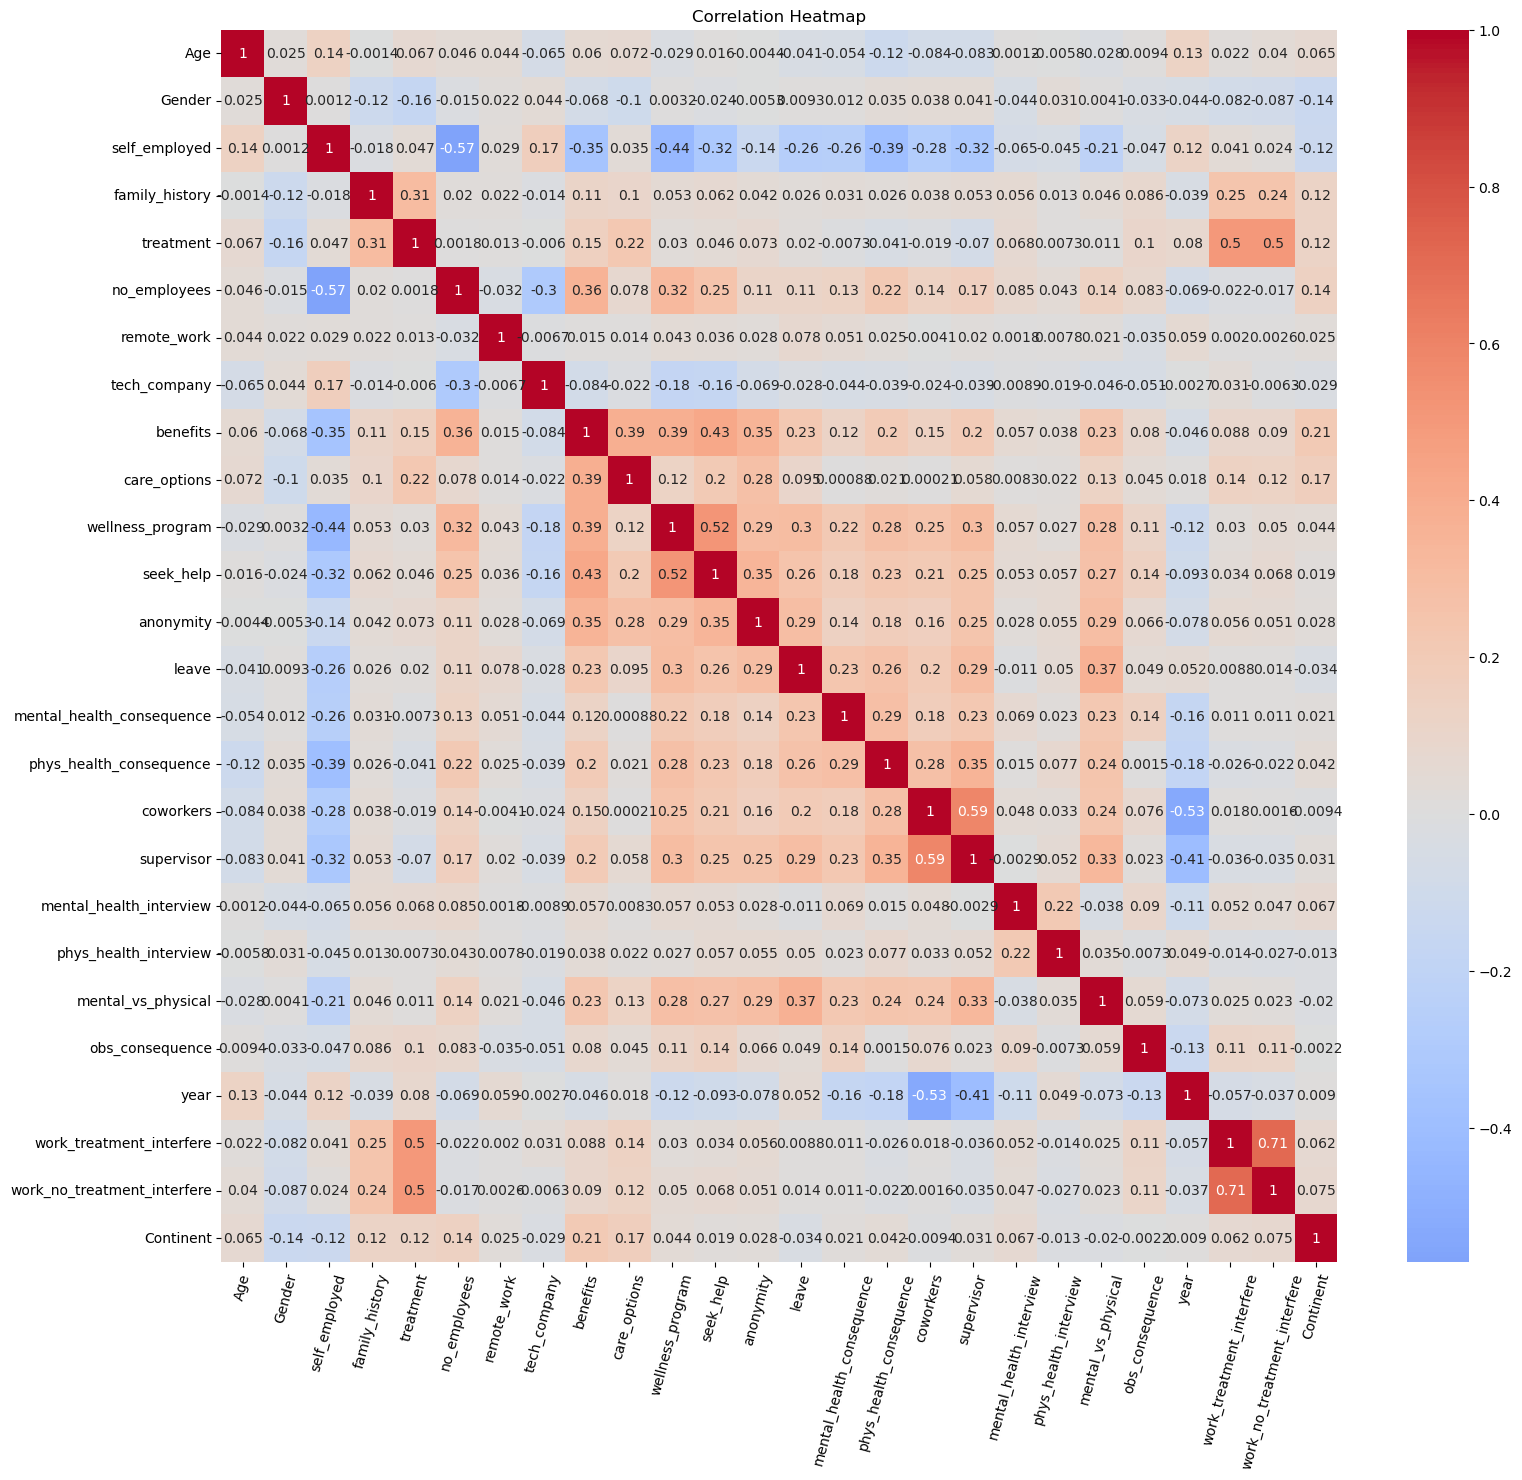

In [232]:
# Calculate the correlation matrix
correlation_matrix = heatmap_data.corr(method= 'spearman' , numeric_only = True)

# Create a heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.xticks(rotation = 75)
plt.show()

we see that 'phys_health_interview' have low correlation with treatment and other features thus we can check the dependency and maybe remove this feature in the predictive model.

In [233]:
find_dependencies(al_mental, 'phys_health_interview')

(0.79646123993654, 'independent')

It is very interesting that the year has some strong dependencies, including with our target feature "treatment".
Let investigate:

In [234]:
print(f'Entries in 2014: {len(al_mental[al_mental.year == 2014])} \nEntries in 2016: {len(al_mental[al_mental.year == 2016])}')

Entries in 2014: 1251 
Entries in 2016: 1423


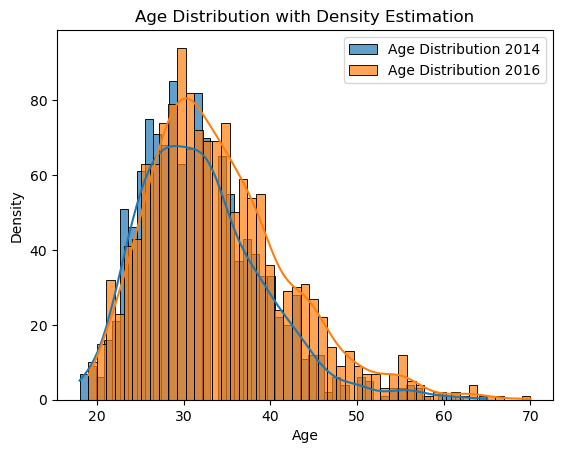

In [235]:
fig, ax = plt.subplots()
sns.histplot(al_mental[al_mental.year == 2014].Age, bins = 50, alpha = 0.7, kde = True, label='Age Distribution 2014')
sns.histplot(al_mental[al_mental.year == 2016].Age, bins = 50, alpha = 0.7, kde = True, label='Age Distribution 2016')

ax.set_xlabel('Age')
ax.set_ylabel('Density')
ax.set_title('Age Distribution with Density Estimation')

plt.legend()
plt.show()

It is also interesting to note the expected strong correlation between 'family_history' and  'treatment','work_treatment_interfere', 'work_no_treatment_interfere'.

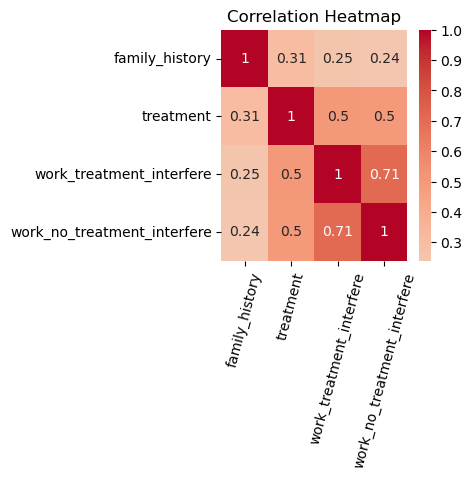

In [236]:
correlation_matrix_tr = heatmap_data[['family_history', 'treatment','work_treatment_interfere', 'work_no_treatment_interfere']].corr(method= 'spearman' , numeric_only = True)

# Create a heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(correlation_matrix_tr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.xticks(rotation = 75)
plt.show()

We see that the distribution is very similar, most probably the dependency comes from the larger number of participants in 2016<br><br>
Expected we strong correlation between 'seek_help' and  'care_options', 'wellness_program' <b>but</b> surprisingly this has less effect on the 'treatment'. It is like even though the company has wellness programs and awareness, something more is needed for the people to look for treatment.<br>


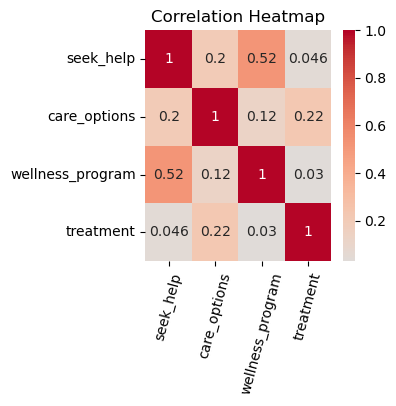

In [237]:
correlation_matrix_tr = heatmap_data[['seek_help', 'care_options', 'wellness_program', 'treatment']].corr(method= 'spearman' , numeric_only = True)

# Create a heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(correlation_matrix_tr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.xticks(rotation = 75)
plt.show()

There is also strong dependency between 'year' and 'coworkers'.
this is clearly something that i have created while preparing the data and [cleaning the NaN values](#my_noice1), as we had 286 such values. <br>
Yet I will not be too hard on myself as even if we remove 286 from the "Maybe" column we will have around 500 "Maybe" answers and it will more or less keep the main trend of the answers.<br> Which shows that in 2016 people were more open to the idea to look for help at the workplace!<br><br>
<b> Having said that, i do believe this can be addressed, analyzed and done differently if we have more domain knowledge etc...</b>

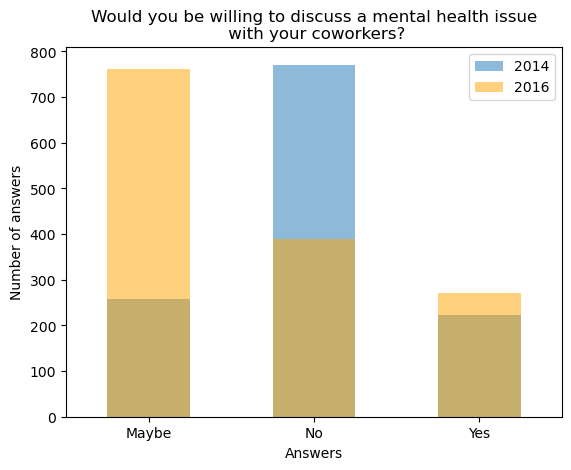

In [238]:
al_mental[al_mental.year == 2014].coworkers.value_counts().sort_index().plot(kind = 'bar', alpha = 0.5)
al_mental[al_mental.year == 2016].coworkers.value_counts().sort_index().plot(kind = 'bar', color = 'orange', alpha = 0.5)

plt.xlabel('Answers')
plt.ylabel('Number of answers')
plt.xticks(rotation = 0)
plt.legend(['2014','2016'])
plt.title('Would you be willing to discuss a mental health issue\n with your coworkers?')

plt.show()

[TOP](#top)
<a id='compare'></a>
## Some comparison between 2014 and 2016

Let show a few charts similar to the one above.

In [239]:
# we will create a dict that thranslates the column to the question asked
# we will do this by reversing the keys and values of column_dict_2014 and column_dict_2016

column_dict_2014_rev = {v: k for k, v in column_dict_2014.items()}
column_dict_2016_rev = {v: k for k, v in column_dict_2016.items()}
column_dict_2016_rev['Continent'] = 'What continent are you living in?'
column_dict_2016_rev['year'] = 'Year of the data'


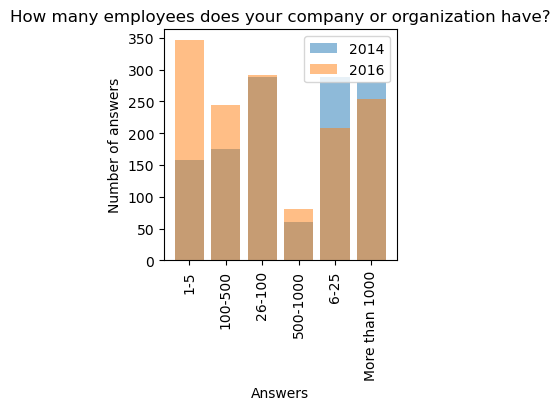

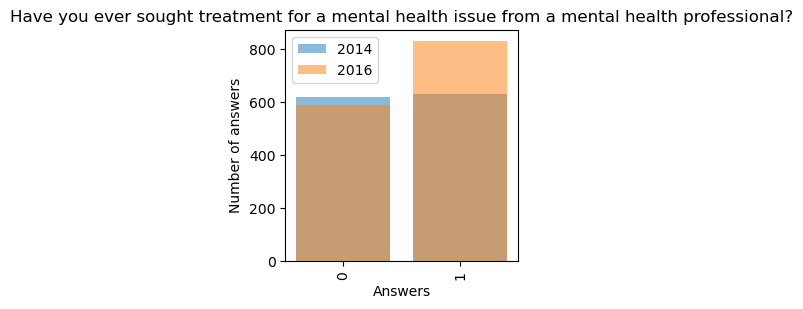

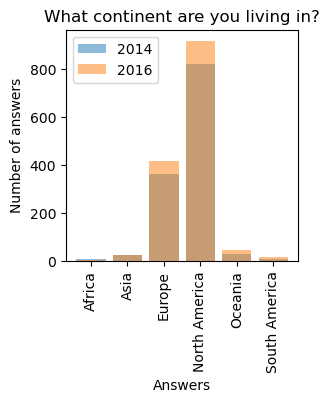

In [240]:
for i in ['no_employees', 'treatment', 'Continent']:
    if i == 'Age': print('The Age data is not suitable for this kind of representation!')
    compare_columns(al_mental,i)

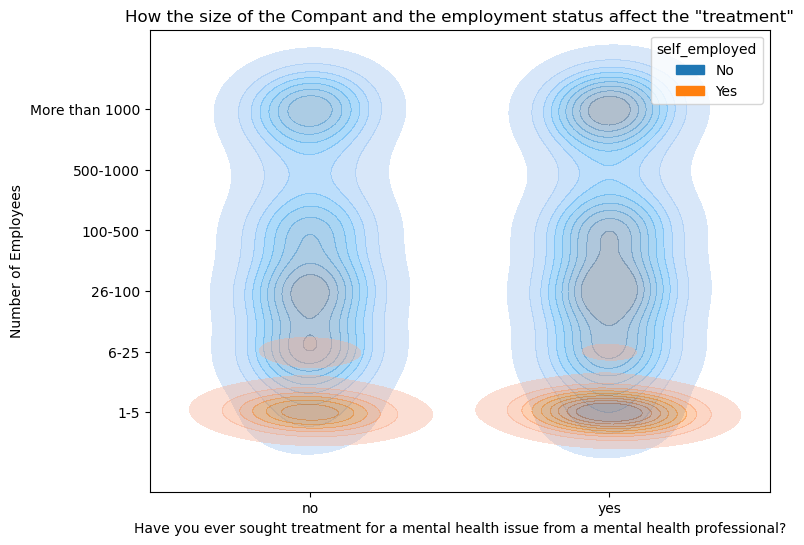

In [241]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=heatmap_data, x="treatment", y="no_employees", hue = al_mental['self_employed'],fill=True, alpha = 0.4)
plt.xticks(ticks= [0,1],labels = ['no', 'yes'])
plt.yticks(ticks=[0,1,2,3,4,5], labels= ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'])
plt.xlabel(column_dict_2016_rev['treatment'])
plt.ylabel('Number of Employees')
plt.title('How the size of the Compant and the employment status affect the "treatment"')
plt.show()

[TOP](#top)
<a id='predict'></a>
## Prediction

Now comes the moment to try to predict who of the participants have sought treatment.<br>
We will use some basic models and will not focus too much on them as this will be a task for the next module.<br>
we will use Classification Algorithms!<br>
Require Normalized data:<br>
Logistic Regression<br>
K Nearest Neighbors (KNN)<br>


Dont require Normalized data:<br>
Random Forest<br>
Naive Bayes<br>

In [242]:
scaler = StandardScaler()
data_norm =  pd.DataFrame(scaler.fit_transform(heatmap_data), columns= heatmap_data.columns)
X_norm = data_norm.drop('treatment', axis = 1)
X = heatmap_data.drop('treatment', axis = 1)
y = heatmap_data['treatment']

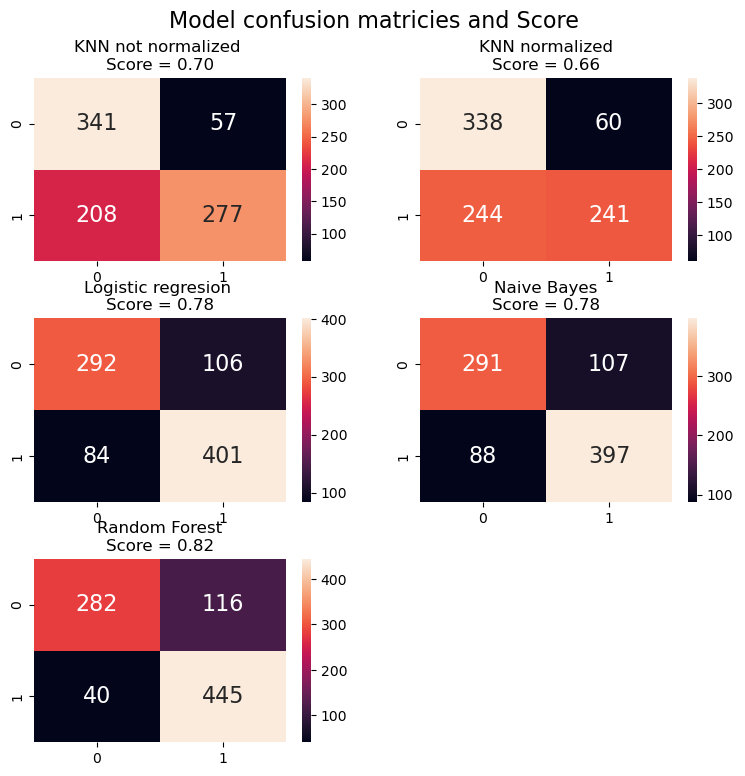

In [243]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 8))

fig.suptitle('Model confusion matricies and Score', fontsize=16)
fig.tight_layout(pad=2.0)

g1 = sns.heatmap(pd.DataFrame(knn(X,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
            fmt = '.3g', ax = ax1)
g1.set_title( label = f'KNN not normalized \nScore = {knn(X,y)[0]:.2f}')

g2 = sns.heatmap(pd.DataFrame(knn(X_norm,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
            fmt = '.3g', ax = ax2)
g2.set_title(label = f'KNN normalized\nScore = {knn(X_norm,y)[0]:.2f}')

g3 = sns.heatmap(pd.DataFrame(logistic_reg(X_norm,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
                        fmt = '.3g', ax = ax3)
g3.set_title(label = f'Logistic regresion \nScore = {logistic_reg(X_norm,y)[0]:.2f}')

g4 = sns.heatmap(pd.DataFrame(bayes(X_norm,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
                        fmt = '.3g', ax = ax4)
g4.set_title(label = f'Naive Bayes\nScore = {bayes(X_norm,y)[0]:.2f}')

g5 = sns.heatmap(pd.DataFrame(rand_forest(X,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
                        fmt = '.3g', ax = ax5)
g5.set_title(label = f'Random Forest\nScore = {rand_forest(X,y)[0]:.2f}')

ax6.axis('off')

plt.show()

### Using PCA

In [244]:
n_comp = 10
pca = PCA(n_components=n_comp)
pca_data = pca.fit_transform(X)
pca_data = pd.DataFrame(data = pca_data, columns = ['principal component'+ str(i) for i in range(1,n_comp+1)])

In [245]:
print(bayes(pca_data,y))

(0.7893544733861835, array([[285, 113],
       [ 73, 412]], dtype=int64))


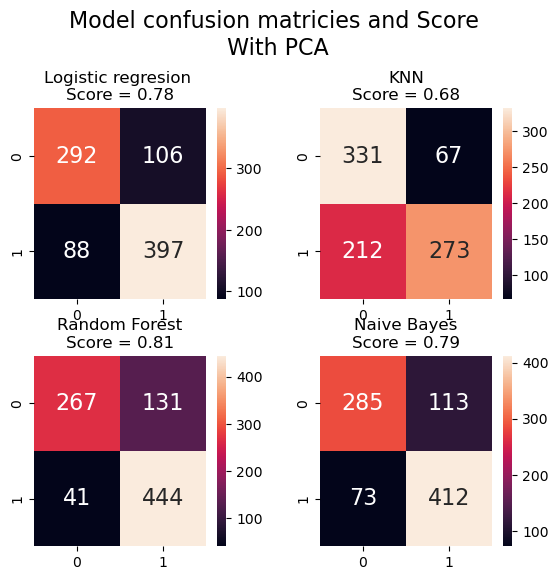

In [246]:
fig_pca, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 6))

fig_pca.suptitle('Model confusion matricies and Score\n With PCA', fontsize=16)
fig_pca.tight_layout(pad=2.0)

g1 = sns.heatmap(pd.DataFrame(logistic_reg(pca_data,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
            fmt = '.3g', ax = ax1)
g1.set_title( label = f'Logistic regresion \nScore = {logistic_reg(pca_data,y)[0]:.2f}')

g2 = sns.heatmap(pd.DataFrame(knn(pca_data,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
            fmt = '.3g', ax = ax2)
g2.set_title(label = f'KNN\nScore = {knn(pca_data,y)[0]:.2f}')

g3 = sns.heatmap(pd.DataFrame(rand_forest(pca_data,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
                        fmt = '.3g', ax = ax3)
g3.set_title(label = f'Random Forest\nScore = {rand_forest(pca_data,y)[0]:.2f}')

g4 = sns.heatmap(pd.DataFrame(bayes(pca_data,y)[1], range(2), range(2)), annot=True, annot_kws={"size": 16}, 
                        fmt = '.3g', ax = ax4)
g4.set_title(label = f'Naive Bayes\nScore = {bayes(pca_data,y)[0]:.2f}')

plt.show()

[TOP](#top)
<a id='con'></a>
## Conclusions

Overall i can mace a few short conclusions:<br>
    1/ Self-employed tent to look for treatment more easier that people working in a company<br>
    2/ People working in very large Companies tent to look for treatment more often<br>
    3/ If Company has benefits and mental health programs and initiatives is more common for the employees to think that would look for help if needed, but in reality this is not enough to for the people to do so. there is strong dependency on how the coworkers and the managers react and handle such cases in the past and present.<br>
    4/ Looking for treatment and working remotely or being self employed are not so strongly dependent<br>
    5/ Having family history of mental health issues helps people to look for treatment<br>
    6/ Even though my predictive models were a disappointment i do believe there is a good way to create a model that can address this and help organizations to help those people is a very early stage! 
    

[TOP](#top)
<a id='ref'></a>
## Reference

[Comparing Strings Is Easy With FuzzyWuzzy Library](https://towardsdatascience.com/string-comparison-is-easy-with-fuzzywuzzy-library-611cc1888d97)<br>
[A Gentle Introduction to the Chi-Squared Test for Machine Learning](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/)<br>
[7 Techniques to Handle Imbalanced Data](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html)
